In [23]:

# coding: utf-8

# In[206]:


# --------------Biblio & modules-------------------------------------
import sys
from sys import argv
from Bio import AlignIO
from Bio import SeqIO
from Bio.Seq import Seq
from time import time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()
from reportlab.lib import colors
from reportlab.lib.units import cm
from Bio.Graphics import GenomeDiagram
from Bio.SeqFeature import SeqFeature, FeatureLocation
import pickle
import matplotlib as mpl
import statistics
from IPython.display import Image


# ---------------------------------Extracting file-----------------------------
if len(sys.argv) == 1:  # input control
    print("Invalid arguments")
    sys.exit(1)

#in_file = open(argv[1], "r")   # It must be a alignment with equal lengths of sequences
#print("Starting LD calculation of ", argv[1])

in_file = open("/home/pavel/Desktop/Work/Project/reader_3.6/Files/seqs/Spiophanes_bombyx_4.fasta", "r")   # It must be a alignment with equal lengths of sequences

# -------------------------------Modules-----------------------------------------
round_ = 4  # The round parameter!
h = 0.25 #float(argv[3])  # The mask parameter!
is_circle = "no"  # circle mode 
print("Default parameters: ", "mask-", h, " circle mode-", is_circle)


def slice_module(slice_number, align_slice):   # It takes a slice bar os sequences and write in to the out_file
    align_slice = align_slice.upper()
    A = align_slice.count("A")
    T = align_slice.count("T")
    G = align_slice.count("G")
    C = align_slice.count("C")
    counter_A_pr = round(float(align_slice.count("A") / len(align_slice)), round_)
    counter_T_pr = round(float(align_slice.count("T") / len(align_slice)), round_)
    counter_G_pr = round(float(align_slice.count("G") / len(align_slice)), round_)
    counter_C_pr = round(float(align_slice.count("C") / len(align_slice)), round_)
    counter_N_pr = round(float(align_slice.count("N") / len(align_slice)), round_)
    counter__pr = round(float(align_slice.count("-") / len(align_slice)), round_)
    if ((counter_A_pr or counter_T_pr or counter_G_pr or counter_C_pr or counter_N_pr or counter__pr) == 1) or (counter_N_pr or counter__pr != 0):
        return 0
    else:
        if A+T == len(align_slice) or A+G == len(align_slice) or A+C == len(align_slice) or T+G == len(align_slice) or T+C == len(align_slice) or G+C == len(align_slice):
            if min(counter_A_pr, counter_T_pr) > h or min(counter_A_pr, counter_G_pr) > h or min(counter_A_pr, counter_C_pr) > h or min(counter_T_pr, counter_G_pr) > h or min(counter_T_pr, counter_C_pr) > h or min(counter_G_pr, counter_C_pr) > h:
                slice_id_dic[slice_number] = align_slice  # Making a dict with seqs and keys
        return 1


def nuc_identification_module(line):  # Looking for nuc and nuc% in line
    array = list(line)
    result = {i: array.count(i) for i in array};
    return result


def duplet_compute_module(duplet_list, A, B):
    A_keys = []
    B_keys = []
    for key in A.keys():
        A_keys = A_keys + [key]
    for key in B.keys():
        B_keys = B_keys + [key]

    p1 = round(A[A_keys[0]]/(A[A_keys[0]] + A[A_keys[1]]), round_)
    p2 = round(A[A_keys[1]]/(A[A_keys[0]] + A[A_keys[1]]), round_)
    q1 = round(B[B_keys[0]]/(B[B_keys[0]] + B[B_keys[1]]), round_)
    q2 = round(B[B_keys[1]]/(B[B_keys[0]] + B[B_keys[1]]), round_)

    p1q1 = str(A_keys[0]) + str(B_keys[0])
    p1q2 = str(A_keys[0]) + str(B_keys[1])
    p2q1 = str(A_keys[1]) + str(B_keys[0])
    p2q2 = str(A_keys[1]) + str(B_keys[1])

    counter_p1q1_pr = round(float(duplet_list.count(p1q1) / len(duplet_list)), round_)
    counter_p1q2_pr = round(float(duplet_list.count(p1q2) / len(duplet_list)), round_)
    counter_p2q1_pr = round(float(duplet_list.count(p2q1) / len(duplet_list)), round_)
    counter_p2q2_pr = round(float(duplet_list.count(p2q2) / len(duplet_list)), round_)
    return counter_p1q1_pr, counter_p1q2_pr, counter_p2q1_pr, counter_p2q2_pr, p1, p2, q1, q2


# -------------------------LD calculation---------------------------
        
        
alignment = AlignIO.read(in_file, "fasta")  # Importing all alignments from in file
in_file.close()


align_slice = ''
slice_id_dic = {}

genome_size = len(alignment[0, :])
for slice_number in range(genome_size):  # Taking a nucleotide from each bar/slice in alignment and from each sequence. For nuc in range of length of seq
    for seq in range(len(alignment)):  # For seq from all seqs
        align_slice = align_slice + str(alignment[seq, slice_number])  # Making slices
    a = slice_module(slice_number, align_slice)  # Collecting it and putting in the slice_module
    align_slice = ''                    
    

    
#LD_out_file = open("LD.txt", "w")
#LD_out_file.write("Len" + "\t" + "LD" + "\n")

#r2_out_file = open("r2.txt", "w")
#r2_out_file.write("Len" + "\t" + "r2" + "\n")

gd_diagram = GenomeDiagram.Diagram("")
gd_track_for_features = gd_diagram.new_track(1, name="Annotated Features")
gd_feature_set = gd_track_for_features.new_set()

Len_list = []
LD_list = []
r2_list = []
for key in list(slice_id_dic):  # For keys in dict
    one = slice_id_dic[key]  # Retrieving a slice
    for q in list(slice_id_dic):
        if key < q:  # if we want to count for a half
            if is_circle == "yes":
                summ = min(abs(int(q) - int(key)), genome_size - abs(int(key) - int(q)))  # Calculating the distance
            if is_circle == "no":
                summ = abs(int(q) - int(key))
            
            two = slice_id_dic[q]
            line1 = one.strip()
            line2 = two.strip()
            A = nuc_identification_module(line1)
            B = nuc_identification_module(line2)

            duplet_list = []
            for i in range(len(line1)):
                duplet_list = duplet_list + [line1[i] + line2[i]]
            AB = duplet_compute_module(duplet_list, A, B)
            LD = AB[0]*AB[3] - AB[1]*AB[2]    # D and LD formula
            if LD >= 0:
                LD_out = round(LD/(min(AB[4]*AB[7], AB[5]*AB[6])), round_)
            if LD < 0:
                LD_out = round(LD/(max(-AB[4]*AB[6], -AB[5]*AB[7])), round_)

            #LD_out_file.write(str(summ) + "\t" + str(LD_out) + "\n")

            r = round((LD**2)/(AB[4]*AB[5]*AB[6]*AB[7]), round_)
            
            if r <= 0.1:
                feature = SeqFeature(FeatureLocation(key, q))
                color = colors.red
                gd_feature_set.add_feature(feature, sigil="ARROW", arrowshaft_height=0.1,
                               color=color, label=True,
                               label_size = 25, label_angle=0)
            if r > 0.1:
                feature = SeqFeature(FeatureLocation(key, q))
                color = colors.blue
                gd_feature_set.add_feature(feature, sigil="ARROW", arrowshaft_height=0.1,
                               color=color, label=True,
                               label_size = 25, label_angle=0)
                
            #r2_out_file.write(str(summ) + "\t" + str(r) + "\n")
            Len_list.append(summ)
            LD_list.append(LD_out)
            r2_list.append(r)
            
#LD_out_file.close() 
#r2_out_file.close() 


# -------------------------Visualization---------------------------

print("Done")



Default parameters:  mask- 0.25  circle mode- no
Done


In [19]:
#gd_diagram.draw(format="linear", fragments=20,start=0, end=len(alignment[0, :]))
#gd_diagram.write("plasmid_linear_nice.png", "PNG")
#Image(filename='plasmid_linear_nice.png') 

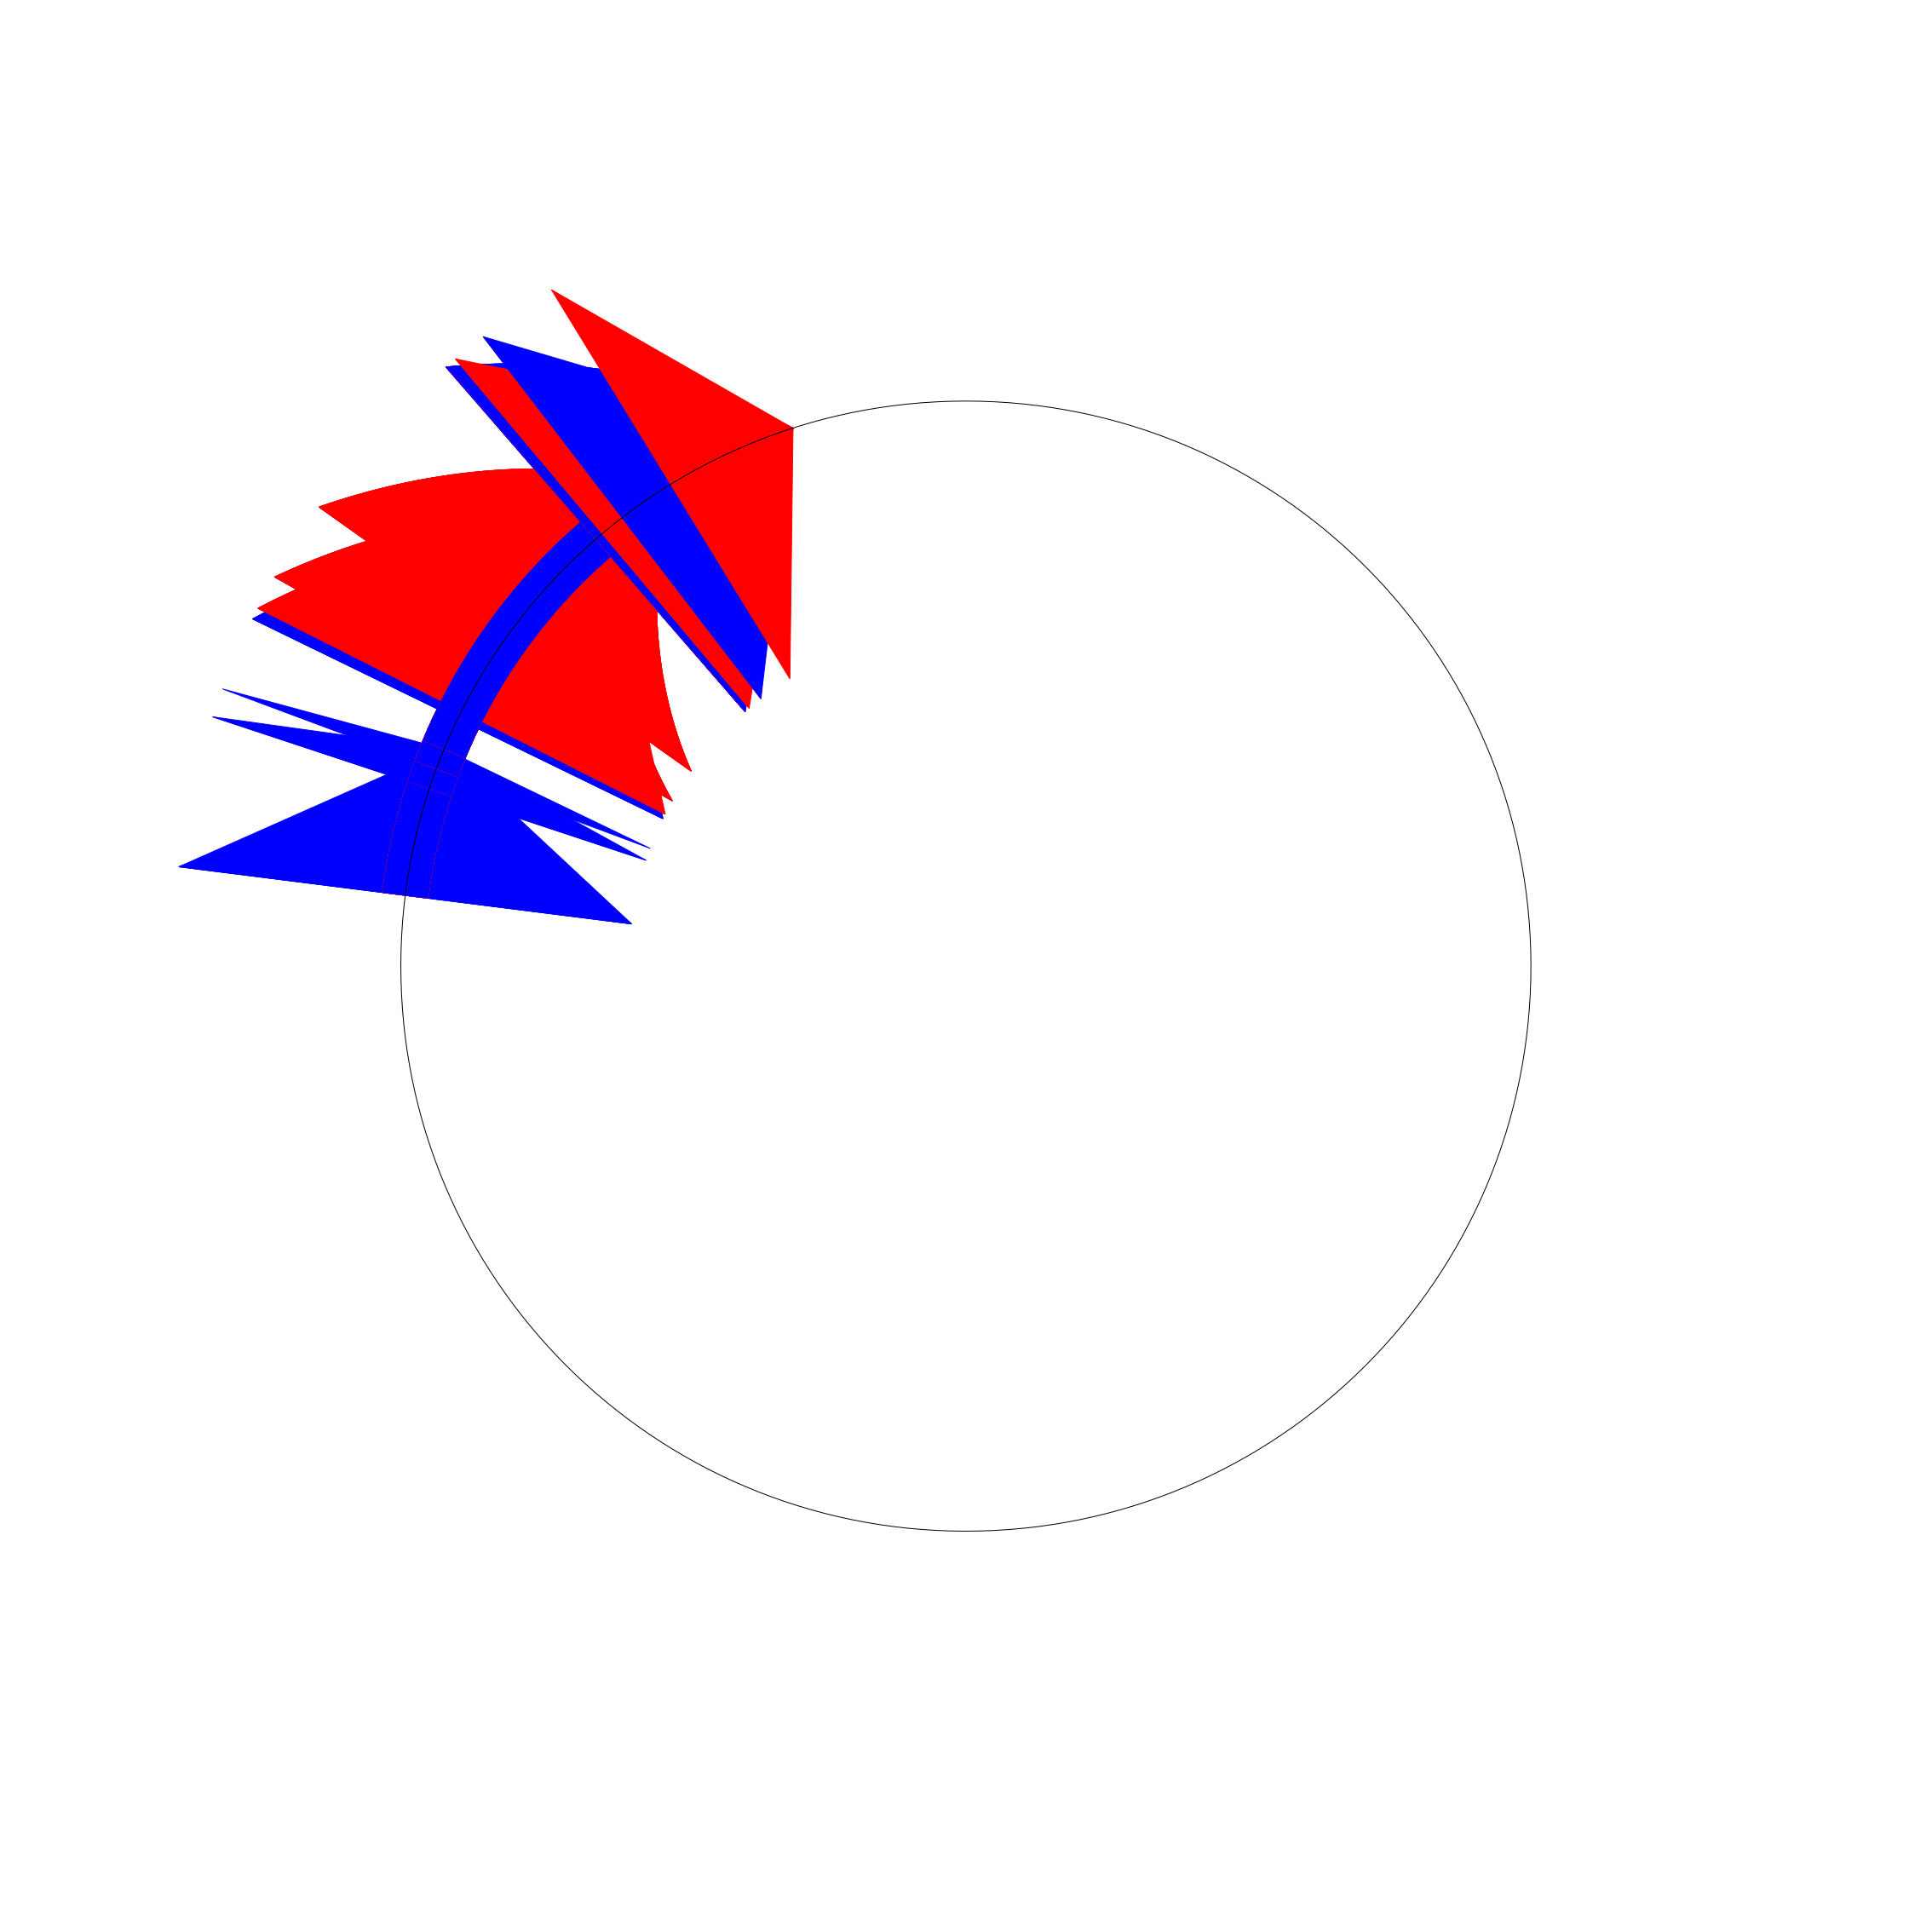

In [22]:
gd_diagram.draw(format="circular", circular=True, pagesize=(80*cm,80*cm), start=0, end=len(alignment[0, :]), circle_core = 0.3)
gd_diagram.write("plasmid_circular_nice.png", "PNG")
Image(filename='plasmid_circular_nice.png') 

In [26]:
from matplotlib.figure import Figure                       
from matplotlib.axes import Axes                           
from matplotlib.lines import Line2D                        
from matplotlib.backends.backend_agg import FigureCanvasAgg

fig = Figure(figsize=[4,4])                                
ax = Axes(fig, [.1,.1,.8,.8])                              
fig.add_axes(ax)                                           
l = Line2D([0,1],[0,1])                                    
ax.add_line(l)             
canvas = FigureCanvasAgg(fig)                              
canvas.print_figure("line_ex.png")  